# Notebook for Master's Thesis

_Jonatan Haraldsson_ [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

_Jesper Noord_ [noord@chalmers.se](mailto:noord@chalmers.se)



In [130]:
# relevant modules for this notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import emcee
import corner
import scipy
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode, uniform
import seaborn as sns
import random
import sklearn
import scipy.constants as const
import random
import tqdm
from tqdm import trange
import keras as keras
import tensorflow as tf

# import  settings
import plot_settings
plot_settings.apply()

np.random.seed(123)

In [131]:
import pybamm


model = pybamm.lithium_ion.DFN()

geometry = model.default_geometry



param = model.default_parameter_values

param.process_model(model)
param.process_geometry(geometry)

mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)



In [132]:
# for var in model.variables:
#     print(var)
for param,paramvals in zip(model.default_parameter_values.keys(),model.default_parameter_values.values()):
    print(f'{param} \t\t {paramvals}')

Ratio of lithium moles to SEI moles 		 2.0
SEI partial molar volume [m3.mol-1] 		 9.585e-05
SEI growth transfer coefficient 		 0.5
SEI reaction exchange current density [A.m-2] 		 1.5e-07
SEI resistivity [Ohm.m] 		 200000.0
SEI solvent diffusivity [m2.s-1] 		 2.5e-22
Bulk solvent concentration [mol.m-3] 		 2636.0
SEI open-circuit potential [V] 		 0.4
SEI electron conductivity [S.m-1] 		 8.95e-14
SEI lithium interstitial diffusivity [m2.s-1] 		 1e-20
Lithium interstitial reference concentration [mol.m-3] 		 15.0
Initial SEI thickness [m] 		 5e-09
EC initial concentration in electrolyte [mol.m-3] 		 4541.0
EC diffusivity [m2.s-1] 		 2e-18
SEI kinetic rate constant [m.s-1] 		 1e-12
SEI growth activation energy [J.mol-1] 		 0.0
Negative electrode reaction-driven LAM factor [m3.mol-1] 		 0.0
Positive electrode reaction-driven LAM factor [m3.mol-1] 		 0.0
Negative current collector thickness [m] 		 2.5e-05
Negative electrode thickness [m] 		 0.0001
Separator thickness [m] 		 2.5e-05
Positive

In [133]:
for v,V in zip(model.variables.keys(), model.variables.values()):
    print(f"\t- {v}\t\t{V}")

	- Time [s]		time
	- Time [min]		0.016666666666666666 * time
	- Time [h]		0.0002777777777777778 * time
	- x [m]		x
	- x_n [m]		x_n
	- x_s [m]		x_s
	- x_p [m]		x_p
	- r_n [m]		r_n
	- r_p [m]		r_p
	- Current variable [A]		Current function [A]
	- Total current density [A.m-2]		Current function [A] / (Electrode width [m] * Electrode height [m] * Number of electrodes connected in parallel to make a cell)
	- Current [A]		Current function [A]
	- C-rate		Current function [A] / Nominal cell capacity [A.h]
	- Discharge capacity [A.h]		Discharge capacity [A.h]
	- Throughput capacity [A.h]		Throughput capacity [A.h]
	- Discharge energy [W.h]		0.0
	- Throughput energy [W.h]		0.0
	- Porosity		concatenation(Negative electrode porosity, Separator porosity, Positive electrode porosity)
	- Negative electrode porosity		Negative electrode porosity
	- X-averaged negative electrode porosity		x-average(Negative electrode porosity)
	- Separator porosity		Separator porosity
	- X-averaged separator porosity		x-

In [159]:
solver = model.default_solver
s = 3600


t_eval = np.linspace(0, s, 100)

print(t_eval.shape)
solution = solver.solve(model, t_eval)

print(len(t_eval))


(100,)
100


In [162]:
N = []
variable_names = []
for vals in model.variables.keys():
    variable_names.append(str(vals))
    N.append(len(solution[vals].entries))
    print(f'{solution[vals].entries.shape} \t {vals}')


(969,) 	 Time [s]
(969,) 	 Time [min]
(969,) 	 Time [h]
(60, 969) 	 x [m]
(20, 969) 	 x_n [m]
(20, 969) 	 x_s [m]
(20, 969) 	 x_p [m]
(20, 20, 969) 	 r_n [m]
(20, 20, 969) 	 r_p [m]
(969,) 	 Current variable [A]
(969,) 	 Total current density [A.m-2]
(969,) 	 Current [A]
(969,) 	 C-rate
(969,) 	 Discharge capacity [A.h]
(969,) 	 Throughput capacity [A.h]
(969,) 	 Discharge energy [W.h]
(969,) 	 Throughput energy [W.h]
(60, 969) 	 Porosity
(20, 969) 	 Negative electrode porosity
(969,) 	 X-averaged negative electrode porosity
(20, 969) 	 Separator porosity
(969,) 	 X-averaged separator porosity
(20, 969) 	 Positive electrode porosity
(969,) 	 X-averaged positive electrode porosity
(60, 969) 	 Porosity change
(20, 969) 	 Negative electrode porosity change [s-1]
(969,) 	 X-averaged negative electrode porosity change [s-1]
(20, 969) 	 Separator porosity change [s-1]
(969,) 	 X-averaged separator porosity change [s-1]
(20, 969) 	 Positive electrode porosity change [s-1]
(969,) 	 X-averaged 

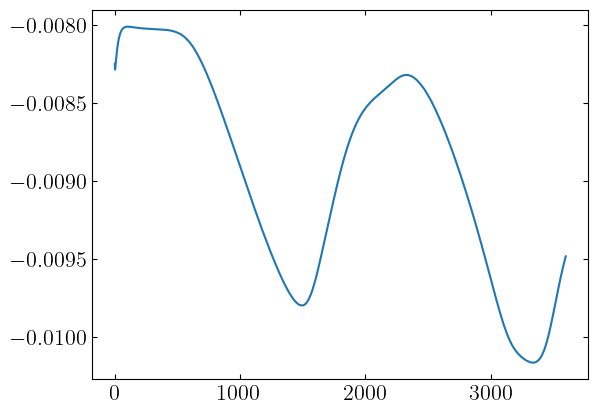

In [163]:
T = solution["Time [s]"].entries
V = solution["X-averaged battery electrolyte ohmic losses [V]"].entries

plt.plot(T,V)

In [67]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from scipy.interpolate import griddata

import pybamm
from pybamm import (
    BaseModel,
    Discretisation,
    Scalar,
    ScikitFiniteElement3D,
)
from pybamm.meshes.scikit_fem_submeshes_3d import ScikitFemGenerator3D

R_outer = 0.6
R_inner = 0.1
H = 1.0
alpha = 0.1

heat_generation = 1000.0
heat_flux_top = 500.0
heat_flux_bottom = -300.0

model = BaseModel()

r = pybamm.SpatialVariable("r", ["current collector"], coord_sys="cylindrical polar")
theta = pybamm.SpatialVariable(
    "theta", ["current collector"], coord_sys="cylindrical polar"
)
z = pybamm.SpatialVariable("z", ["current collector"], coord_sys="cylindrical polar")
T = pybamm.Variable("T", domain="current collector")

source_term = pybamm.source(heat_generation, T)

model.algebraic = {T: alpha * pybamm.laplacian(T) + source_term}
model.initial_conditions = {T: Scalar(25)}

model.boundary_conditions = {
    T: {
        "r_min": (Scalar(100), "Dirichlet"),
        "r_max": (Scalar(20), "Dirichlet"),
        "z_min": (Scalar(heat_flux_bottom), "Neumann"),
        "z_max": (Scalar(heat_flux_top), "Neumann"),
    }
}

geometry = {
    "current collector": {
        r: {"min": pybamm.Scalar(R_inner), "max": pybamm.Scalar(R_outer)},
        z: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(H)},
    }
}

submesh_types = {
    "current collector": ScikitFemGenerator3D(geom_type="cylinder", h=0.08)
}

var_pts = {r: None, theta: None, z: None}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
spatial_methods = {"current collector": ScikitFiniteElement3D()}
disc = Discretisation(mesh, spatial_methods)
disc.process_model(model)

solver = pybamm.AlgebraicSolver()
solution = solver.solve(model)

nodes = mesh["current collector"].nodes
T_solution = solution.y.flatten()

print(f"Number of FEM nodes: {nodes.shape[0]}")
print(f"Temperature range: [{T_solution.min():.2f}, {T_solution.max():.2f}]°C")

Nr_vis, Ntheta_vis, Nz_vis = 30, 40, 25
r_grid = np.linspace(R_inner, R_outer, Nr_vis)
theta_grid = np.linspace(0, 2 * np.pi, Ntheta_vis)
z_grid = np.linspace(0, H, Nz_vis)
R_grid, Theta_grid, Z_grid = np.meshgrid(r_grid, theta_grid, z_grid, indexing="ij")

X_grid = R_grid * np.cos(Theta_grid)
Y_grid = R_grid * np.sin(Theta_grid)
grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel(), Z_grid.ravel()])

T_interpolated = griddata(
    nodes, T_solution, grid_points, method="linear", fill_value=np.nan
).reshape((Nr_vis, Ntheta_vis, Nz_vis))


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


Number of FEM nodes: 2268
Temperature range: [18.99, 501.00]°C


In [66]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Heat Distribution with Source Term and Neumann BCs", fontsize=16)

mid_k = Nz_vis // 2
R_plane = R_grid[:, :, mid_k]
Theta_plane = Theta_grid[:, :, mid_k]
T_plane = T_interpolated[:, :, mid_k]
ax1.remove()
ax1 = fig.add_subplot(2, 2, 1, projection="polar")
pcm1 = ax1.contourf(Theta_plane, R_plane, T_plane, levels=20, cmap="plasma")
ax1.set_title(f"T(r,θ) at z={H / 2:.1f}m")
ax1.set_ylim(R_inner, R_outer)
fig.colorbar(pcm1, ax=ax1)

mid_j = 0
R_axial = R_grid[:, mid_j, :]
Z_axial = Z_grid[:, mid_j, :]
T_axial = T_interpolated[:, mid_j, :]
pcm2 = ax2.contourf(R_axial, Z_axial, T_axial, levels=20, cmap="plasma")
ax2.set_xlabel("r [m]")
ax2.set_ylabel("z [m]")
ax2.set_title("T(r,z) - Shows effect of Neumann BCs")
ax2.set_aspect("equal")
fig.colorbar(pcm2, ax=ax2)

unique_z_coords = np.unique(nodes[:, 2])
mid_plane_z = unique_z_coords[np.argmin(np.abs(unique_z_coords - H / 2))]

z_mid_indices = nodes[:, 2] == mid_plane_z
z_mid_nodes = nodes[z_mid_indices]
T_mid = T_solution[z_mid_indices]

triang = tri.Triangulation(z_mid_nodes[:, 0], z_mid_nodes[:, 1])
pcm3 = ax3.tricontourf(triang, T_mid, levels=20, cmap="plasma")
ax3.plot(
    R_outer * np.cos(np.linspace(0, 2 * np.pi, 100)),
    R_outer * np.sin(np.linspace(0, 2 * np.pi, 100)),
    "k-",
    linewidth=2,
)
ax3.plot(
    R_inner * np.cos(np.linspace(0, 2 * np.pi, 100)),
    R_inner * np.sin(np.linspace(0, 2 * np.pi, 100)),
    "w-",
    linewidth=2,
)
ax3.set_xlabel("x [m]")
ax3.set_ylabel("y [m]")
ax3.set_title("FEM Solution at Mid-Height")
ax3.set_aspect("equal")
fig.colorbar(pcm3, ax=ax3, label="Temperature [°C]")

z_line = np.linspace(0, H, 100)
mid_radius = (R_inner + R_outer) / 2
axial_points = np.column_stack(
    [np.full_like(z_line, mid_radius), np.zeros_like(z_line), z_line]
)
T_axial_profile = griddata(nodes, T_solution, axial_points, method="linear")
ax4.plot(z_line, T_axial_profile, "b-", linewidth=3, label="FEM solution")
ax4.axhline(100, color="r", linestyle="--", alpha=0.7, label="Inner BC (100°C)")
ax4.axhline(20, color="g", linestyle="--", alpha=0.7, label="Outer BC (20°C)")
ax4.set_xlabel("z [m]")
ax4.set_ylabel("Temperature [°C]")
ax4.set_title("Axial Temperature Profile\n(shows Neumann BC effects)")
ax4.legend()
ax4.grid(True, alpha=0.3)

ax4.text(
    0.05,
    T_axial_profile[5],
    f"q = {heat_flux_bottom} W/m²\n(cooling)",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"),
)
ax4.text(
    0.85,
    T_axial_profile[-5],
    f"q = {heat_flux_top} W/m²\n(heating)",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"),
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


def find_closest_node(target_point, nodes):
    distances = np.linalg.norm(nodes - target_point, axis=1)
    return np.argmin(distances)


inner_point = np.array([R_inner, 0, H / 2])
outer_point = np.array([R_outer, 0, H / 2])
mid_point = np.array([(R_inner + R_outer) / 2, 0, H / 2])
bottom_point = np.array([(R_inner + R_outer) / 2, 0, 0])
top_point = np.array([(R_inner + R_outer) / 2, 0, H])

inner_idx = find_closest_node(inner_point, nodes)
outer_idx = find_closest_node(outer_point, nodes)
mid_idx = find_closest_node(mid_point, nodes)
bottom_idx = find_closest_node(bottom_point, nodes)
top_idx = find_closest_node(top_point, nodes)

print("\n" + "=" * 60)
print("HEAT DISTRIBUTION WITH SOURCE TERM AND NEUMANN BCs")
print("=" * 60)
print("Boundary Conditions:")
print(f"  Inner radius (r={R_inner}m): T = 100°C (Dirichlet)")
print(f"  Outer radius (r={R_outer}m): T = 20°C (Dirichlet)")
print(f"  Bottom surface (z=0): q = {heat_flux_bottom} W/m² (Neumann - cooling)")
print(f"  Top surface (z={H}m): q = {heat_flux_top} W/m² (Neumann - heating)")
print(f"  Volumetric heat source: Q = {heat_generation} W/m³")
print("\nTemperature Results:")
print(f"  Inner surface: {T_solution[inner_idx]:.1f}°C")
print(f"  Outer surface: {T_solution[outer_idx]:.1f}°C")
print(f"  Mid-radius center: {T_solution[mid_idx]:.1f}°C")
print(f"  Bottom center: {T_solution[bottom_idx]:.1f}°C")
print(f"  Top center: {T_solution[top_idx]:.1f}°C")
print(f"  Overall range: [{T_solution.min():.1f}, {T_solution.max():.1f}]°C")

temp_rise_axial = T_solution[top_idx] - T_solution[bottom_idx]
print(f"\nAxial temperature rise due to Neumann BCs: {temp_rise_axial:.1f}°C")
print("This demonstrates how:")
print("  1. Positive Neumann flux (top) heats the surface")
print("  2. Negative Neumann flux (bottom) cools the surface")
print("  3. Source term raises overall temperature level")



KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x119ef0cc0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'T(r,\\u03b8) at z=0.5m'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2025) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./file.tex
LaTeX2e <2024-11-01> patch level 2
L3 programming layer <2025-01-18>
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/article.cls
Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2025/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2025/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2025/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2025/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2025/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character θ (U+03B8)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\rmfamily T(r,θ
                      ) at z=0.5m}%
No pages of output.
Transcript written on file.log.




RuntimeError: latex was not able to process the following string:
b'T(r,\\u03b8) at z=0.5m'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2025) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./file.tex
LaTeX2e <2024-11-01> patch level 2
L3 programming layer <2025-01-18>
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/article.cls
Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2025/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2025/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2025/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2025/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2025/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character θ (U+03B8)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\rmfamily T(r,θ
                      ) at z=0.5m}%
No pages of output.
Transcript written on file.log.




<Figure size 1500x1200 with 7 Axes>